# Epidemic Models on Networks

In this set of lecture notes, we'll briefly study an elementary model of epidemic spread on networks. Networks are a natural representation of the patterns of human contact. A so-called *contact network* is a network in which nodes are individuals and edges represent "contact events" between individuals, such as a meeting or conversation. If one has access to a contact network, one can then combine that information with a model of how a disease spreads from individual to individual in order to simulate how a disease might spread on that population. 

In these notes, we'll implement and visualize a very simple model of epidemics on networks, using NetworkX and our good friend, linear algebra. 

## Another Note on Performance

Epidemic simulations can be quite computationally intensive, and for models on large networks, one generally needs some combination of: 

1. More powerful hardware. 
2. [Faster](https://igraph.org/python/), possibly [dedicated software](https://arxiv.org/pdf/2001.02436.pdf) (i.e. not NetworkX).
3. Mathematical approximations to reduce the size of the network.

## The SIR Model

The SIR model is one of many [*compartmental* models](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#:~:text=The%20SIR%20model%20is%20one,The%20number%20of%20susceptible%20individuals.) of epidemic spread. It has three compartments: 

- **S**usceptible. These are individuals who aren't currently sick, but could get sick later. 
- **I**nfected. These are individuals who are currently sick. 
- **R**ecovered. These are individuals who can't get sick, possibly because they have already had a disease and generated immunity upon their recovery. More morbidly, deceased individuals can also be viewed as "recovered" in the sense that they no longer transmit the disease. 

Schematically, we can write 

$$S \rightarrow I \rightarrow R$$ 

to indicate the "flow" of individuals between compartments: susceptible individuals become infected, infected individuals eventually recover. 

## Math Formulation

The SIR model is often written in continuous-time form as a system of ordinary differential equations. It can, however, be difficult to incorporate network structure into continuous time models. Instead, we're going to use a discrete-time model today, with the following logic: 

1. At each timestep $t$, every Susceptible individual `i` is *exposed* to their neighbors. 
2. For each Infected neighbor `j` of `i`, we'll flip a weighted coin with weight `p`. If any of these coins come up heads, then `i` becomes Infected.
3. Concurrently, every Infected individual `k` flips a weighted coin with weight `q`. If this coin comes up heads, then the Infected individual `k` becomes Recovered.  

We are going to implement this model as a class, which holds a NetworkX graph, as well as its adjacency matrix $\mathbf{A}$ encoding connections between nodes. We'll be able to avoid for-loops, for the most part, by using Numpy operations. 

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Architecture

In Python, the right approach to complex simulations is often object-oriented. With this in mind, we're going to build a class whose instance variables represent system states and structures. These include the graph and adjacency matrix; a log of the current states of each node, and so on. We'll then define methods for: 

- Infecting an initial node. 
- Advancing the simulation by one timestep (this is where the math is). 
- Computing the fractions of Susceptible, Infected, and Recovered individuals. 
- Visualizing the history of the process (should only be used on small networks). 

We'll represent each of the three disease categories by integer labels: `0` means Susceptible, `1` means Infected, and `2` means Recovered. 

## Some Experiments

Oooph, that's a lot of methods! Let's use our class to perform some simulations. For now, we'll just arbitrarily choose infection and recovery rates. 

To begin with, let's simulate an epidemic on the Karate Club graph: 

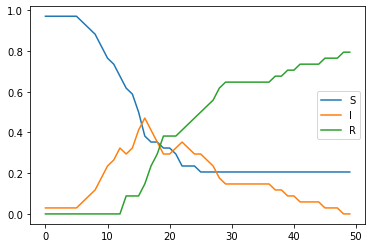

This figure shows the characteristic structure of an SIR model. The **I** curve is perhaps most interesting, as this shows the number of active cases of disease at any given moment. Generally speaking: 

- The **S**usceptible curve always begins at 1.0 and then decreases, possibly to 0, as disease spreads. 
- The **I**nfected curve typically increases (as the disease spreads rapidly) and then decreases (as the disease struggles to find new Susceptible individuals). 
- The **R**ecovered curve always begins at 0.0 and then increaes, possible to 1.0, as disease spreads. 

Because this is a small network, we can also take a look at the history of how this disease spread on the network. 

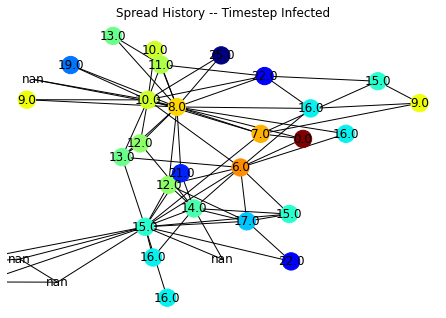

Here, red nodes were infected early in the process, while blue nodes were infected late in the simulation. Nodes labeled `nan` were not infected in this simulation. 

# Larger graph

We can simulate epidemics on much larger graphs, although this can take some time. Let's go back to the Facebook graph from a previous lecture. 

In [7]:
url = "https://raw.githubusercontent.com/PhilChodrow/PIC16B/master/datasets/facebook_combined.txt"
facebook = pd.read_csv(url, 
                       delimiter = " ",
                       names = ["source", "target"])
G = nx.from_pandas_edgelist(facebook)

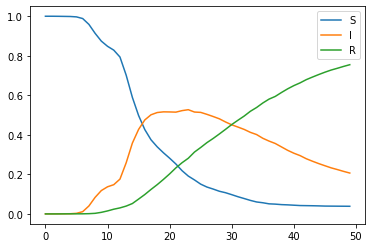

## The Epidemic Threshold

What determines whether or not an epidemic will break out in a population? The answer to this question is Very Complicated, but there is a useful mathematical fairytale we often tell, which can give some useful intuition. 

To start, let's suppose that we live in a very simple world in which each Infected individual always infects, on average, $R_0$ other individuals. In such a world, if we start with a single infected individual, then in timestep $t$ there will be approximately $R_0^t$ individuals infected. If $R_0 > 1$ then this corresponds to exponential growth, while if $R_0 < 1$ then this corresponds to exponential decay. $R_0$ is often referred to as the *basic reproductive number* of the infection, although many modern epidemiologists deny that there really is a single such number that can be measured independent of various external contexts. 

Let's estimate $R_0$ in a network in which each node has, on average, 10 neighbors. A simple way to create such a graph is via the `nx.erdos_renyi_graph()` function, which creates a completely randomized graph in which every node is equally likely to be connected to any other node. 


In [10]:
n = 200
G = nx.erdos_renyi_graph(n, 10/n)
c = np.mean([d for i, d in nx.degree(G)]) # mean degree
c

10.08

Let $\beta$ be the infection rate, and $\nu$ be the recovery rate. Suppose that node $i$ becomes Infected, and most of $i$'s neighbors are still Susceptible. In each timestep, the expected number of neighbors that $i$ will infect is roughly $c\beta$, where $c$ is the mean degree (number of neighbors of $i$). On the other hand, there are in expectation $\frac{1}{\nu}$ timesteps until $i$ recovers. So, a very casual estimate of $R_0$ in this model is 

$$R_0 \approx c\frac{\beta}{\nu}$$

The condition $R_0 > 1$ is the same as the condition $\beta > \frac{\nu}{c}$. So, we'll do an experiment in which we vary the infection rate, while keeping the recovery rate and mean degree constant. We can then see what happens as we cross the epidemic threshold. 

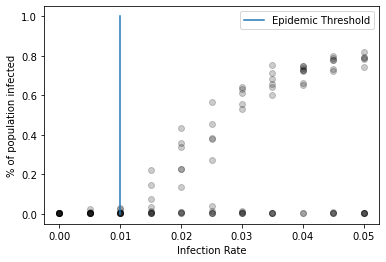

In [11]:
infection_rates = np.linspace(0.0, 0.05, 11)
recovery_rate = 0.1

fig, ax = plt.subplots(1)
threshold = recovery_rate/c
ax.plot([threshold, threshold], [0, 1], label = "Epidemic Threshold")
# critical value of infection rate is around 0.01

for ir in infection_rates:
    for i in range(10):
        epi = SIR(G)
        X = epi.simulate(100, infection_rate = ir, recovery_rate = recovery_rate)
        ax.scatter([ir], [2*X[:,1:].mean()], color = "black", alpha = 0.2)   
        
ax.set(xlabel = "Infection Rate", ylabel = "% of population infected")
ax.legend()

As we cross the epidemic threshold, the behavior of the system qualitatively changes. Prior to the threshold, close to 0% of the population is Infected. After we cross the threshold, however, there are two possibilities. First, the disease may die out, with essentially no infections. On the other hand, the disease might also take off, infecting a large fraction of the population. 

## Methodological Issues

Well, this was a pretty clean set of results. Is epidemiology easy?

Of course it's not! In fact, while the above is a useful set of experiments to help us build our understanding, **nothing** that we did above is unproblematic:

1. **What really is a contact network**, and how do we measure it? Ideally, we'd have measurements not of social relationships, but of actual, face-to-face interactions between individuals. This is very difficult data to get. Some examples are available at the [SocioPatterns project](http://www.sociopatterns.org/datasets/). 
2. Is there such a thing as **"the" infection rate** or **"the" recovery rate**? We just assumed above that these were single numbers which were the same for all individuals at all times. In practice, it can be difficult to measure these numbers, and it's not always even clear that there really is such a thing as an "infection rate" independent of context. 
3. **Network dependencies**. We worked on just a few networks above, and our final example was an unrealistically simple example of a network in which everyone has equal probability to be connected to everyone else. Real-world networks are much more complex than this, and figuring in that complexity is a very challenging task. 
4. **Is SIR a good model?** No! It is a mathematical fairytale. Modern compartmental models are much more complex, including multiple stages of infection, possible reinfection, quarantine states, etc. 

One model that places special emphasis on the use of network methods in the modeling of epidemics is [GLEAM](http://www.gleamviz.org/), a multi-institution model operated jointly by Northeastern University and the ISI Foundation in Italy. 

## Modeling Interventions

One of the nice features of mathematical models they suggests some natural ways to think about interventions, like vaccination, mask-wearing, or social distancing. 

- **Social distancing**: reduce or delete the numbers of contacts between individuals. 
- **Vaccination**: move vaccinated nodes immediately to the Recovered category, or introduce a new Vaccinated category. 
- **Mask-wearing**: reduce the infection rate. 

While modern models used by practicing epidemiologists are much more complex than what we described here, many of the major ideas are still in use. 

For (much) more on mathematical epidemiology, you may be interested in consulting [this textbook](https://zums.ac.ir/files/socialfactors/files/An_Introduction_to_Mathematical_Epidemiology-2015.pdf). 